# Design of Digital Filters

*This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Digital Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).*

## Typical 1st & 2nd Order IIR-Filters in Audio Signal Processing

### Preliminaries

We often use standard LaTex-style citing within the text. At the moment there is no commonly accepted long-term solution for rendering a reference bib-list in a Jupyter notebook automatically, so we leave the bibtex information here as plain text as well. However, it is working with enabled `LaTeX environments for Jupyter` of the `Nbextensions` using the external `biblio.bib` file in the `jupyter notebook` environment. Otherwise, digital resources appear linked with their URLs and you might check [biblio.bib](biblio.bib) manually.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

Import functions for filter coefficients calculation and plotting from accompanying [audiofilter.py](audiofilter.py) next.

In [2]:
import audiofilter

We want to print filter coefficients in high precision. This is useful when e.g. working with fixed point number representation and checking whether its resolution fits for the filter coefficients' dynamic range. So we set up

In [3]:
np.set_printoptions(floatmode='unique')

 We define the sampling frequency in Hz as constant throughout this notebook

In [4]:
fs = 48000

### Introduction

We recollect common 1st and 2nd order infinite impulse response (IIR) audio filters as analog Laplace domain transfer functions and derive their transfer function counterparts in z-domain as bilinear transforms, applying prewarping for cut/mid frequency and for quality/bandwidth.

If you are interested in a Matlab based implementation of these filters, please have a look at the TU Berlin project [AKTools](https://www.ak.tu-berlin.de/menue/publications/open_research_tools/aktools/), cf. [Fabian Brinkmann, Stefan Weinzierl: "AKtools -- An Open Software Toolbox for Signal Acquisition, Processing, and Inspection in Acoustics." In: *142nd AES Convention, Berlin, Germany, 2017*, e-Brief 309.](http://www.aes.org/e-lib/browse.cfm?elib=18685)

Although more sophisticated filter designs exist, the discussed filter characteristics solve many IIR based audio filtering tasks, such as in a typical [digital audio workstation](https://en.wikipedia.org/wiki/Digital_audio_workstation) (DAW) and available [plugins](https://plugins.iem.at/), in digital mixing consoles, loudspeaker management systems, power amplifiers with DSP capabilities, audio player software and home entertainment systems. 

Higher order IIR filters can be built from second order filters. A series connection of the discussed filter types achieves more complex transfer functions often being used in the mentioned applications. A so called graphical equalizer is a prominent example for that, which is however not restricted to build from series connection.

A brilliant, open access review on digital audio filter design is \cite{ValimakiReiss2016} [Vesa Välimäki, Joshua D. Reiss (2016): "All About Audio Equalization: Solutions and Frontiers."
In: *Appl. Sci.*, **6**(5), 129, https://doi.org/10.3390/app6050129](https://doi.org/10.3390/app6050129). The filters derived there in Sec. 3 are consistent with our later called **type III** filters.

#### Standardized vs. Non-Standardized Filter Characteristics
For the **standardized** lowpass, highpass, bandpass, bandstop and allpass filters, the Laplace transfer functions and their coefficients are well known from literature e.g. \cite{Moschytz1981}, [\cite{TietzeSchenk2002}](http://www.tietze-schenk.de/).

For shelving and parametric filters **no standardization w.r.t. the pole/zero qualities and cut-frequencies and thus positions of poles and zeros** exists. Based on \cite{Zoelzer2002,Zoelzer2005},[\cite{Zoelzer2008}](https://link.springer.com/chapter/10.1007/978-3-540-34301-1_15),[\cite{Zoelzer2011}](https://doi.org/10.1002/9781119991298) (in which these filters are derived with the help of allpass filters) and some other articles \cite{Kimball1938}, \cite{Bristow-Johnson}, [\cite{Bristow-Johnson1994}](http://www.aes.org/e-lib/browse.cfm?elib=6326), [\cite{Orfanidis1997}](http://www.aes.org/e-lib/browse.cfm?elib=7854), [\cite{Christensen2003}](http://www.aes.org/e-lib/browse.cfm?elib=12429) widely used approaches can be found.

\cite{Christensen2003} discusses the generalized form of the biquad transfer function for progammable filters.

Three characteristics (labeled as types **I, II and III**) are most prominent, leading to different transfer functions for the same parameter set. This regularly leads to misconceptions. In 2016 the Audio Engineering Society (AES) readdressed this [issue at 141st AES Convention in Los Angeles](http://www.aes.org/events/141/workshops/?ID=5197).

#### Overview of Filter Transfer Functions

The following filter characteristics are discussed in this notebook:

[1st order lowpass](#lowpass1st)

[2nd order lowpass](#lowpass2nd)

[1st order highpass](#highpass1st) 

[2nd order highpass](#highpass2nd)

[2nd order bandpass](#bandpass2nd) 

[2nd order bandstop](#bandstop2nd)

[1st order allpass](#allpass1st) 

[2nd order allpass](#allpass2nd)

[2nd order PEQ](#peq2nd) type **I,I,III**

[1st order low-shelving](#lowshv1st) type **I,I,III**

[2nd order low-shelving](#lowshv2nd) type **I,I,III**

[1st order high-shelving](#highshv1st) type **I,I,III**

[2nd order low-shelving](#highshv2nd) type **I,I,III**

### Bilinear Transform of an IIR Biquad

The transformation of the analog filter prototypes (given as Laplace transfer function) towards the digital prototype (given as z-domain transfer function) is here performed with the [bilinear transform](bilinear_transform.ipynb) \cite[Ch. 7.1.2]{OppenheimSchaferBuck2004}) applying frequency and bandwidth prewarping techniques.

There are other approaches such as the impulse invariant method, the matched z-transform method and higher order Taylor series truncations \cite{Clark2000}, \cite{Gunness2007}, \cite{Alaoui2007}, \cite{Schmidt2010}, \cite{Alaoui2010} that yield higher precision matching of the analog and digital transform. For didactical purpose we restrict ourselves to the bilinear transform of IIR biquads, which is widely used in practice as well.

Let us define the angular frequency $\omega$ in rad/s, $\mathrm{i}^2=-1$ and the sampling frequency $f_s$ in Hz. The connection between the Laplace domain and the z-domain is then given by

\begin{equation}
s = \mathrm{i}\,\omega \qquad z = \mathrm{e}^{\frac{s}{f_s}} \qquad \stackrel{\text{linearization from Taylor series}}{\rightarrow} \qquad s = 2\,f_s\,\frac{z-1}{z+1}.
\end{equation}

The continuous and discrete-time transfer functions $H(s)$ and $H(z)$, respectively for the 2nd order filter (biquad) are given as 

\begin{equation}
H(s) = \frac{B_0\,s^2+B_1\,s+B_2}{A_0\,s^2+A_1\,s+A_2}
\qquad
H(z) = \frac{b_0+b_1\,z^{-1}+b_2\,z^{-2}}{1+a_1\,z^{-1}+a_2\,z^{-2}}
\end{equation}

following typical conventions for the denotation of the filter coefficients $A$, $B$, $a$, $b$ (Python and Matlab compatible).

The bilinear transform rule $s = 2\,f_s\,\frac{z-1}{z+1}$ can be inserted to $H(s)$ and the result can be brought to form of biquad given as $H(z)$ above. Then the coefficients for the biquad are generally given by, cf. [bilinear transform](bilinear_transform.ipynb)

\begin{align}
b_0 &= \frac{B_2+2\,B_1\,f_s+4\,B_0\,f_s^2}{A_2+2\,A_1\,f_s+4\,A_0\,f_s^2}\newline
b_1 &= \frac{2\,B_2-8\,B_0\,f_s^2}{A_2+2\,A_1\,f_s+4\,A_0\,f_s^2}\newline
b_2 &= \frac{B_2-2\,B_1\,f_s+4\,B_0\,f_s^2}{A_2+2\,A_1\,f_s+4\,A_0\,f_s^2}\newline
a_1 &= \frac{2\,A_2-8\,A_0\,f_s^2}{A_2+2\,A_1\,f_s+4\,A_0\,f_s^2}\newline
a_2 &= \frac{A_2-2\,A_1\,f_s+4\,A_0\,f_s^2}{A_2+2\,A_1\,f_s+4\,A_0\,f_s^2}.
\end{align}

The function `bilinear_biquad()` realizes the bilinear transformation based on the above given equations.

### Frequency and Bandwidth Prewarping

A so called prewarping \cite[eq. (7.28)]{OppenheimSchaferBuck2004} of the cut/mid frequency $f_c$/$f_m$ in Hz

\begin{equation}
\omega_{c} \Leftarrow 2\,f_s\,\tan{\left(\pi\frac{f_{c}}{f_s}\right)}
\qquad
\omega_{m} \Leftarrow 2\,f_s\,\tan{\left(\pi\frac{f_{m}}{f_s}\right)}
\end{equation}

is realized in the function `f_prewarping()`.

The connection between the bandwidth $BW_\text{oct}$ in octaves and the corresponding bandpass-related quality $Q_\text{BP}$ is given as

\begin{equation}
BW_\text{oct} = \frac{2}{\log_\mathrm{e}(2)}\,\sinh^{-1}(\frac{1}{2\,Q_\text{BP}})
\qquad
Q_\text{BP} = \frac{1}{2\,\sinh(\frac{\log_\mathrm{e}(2)}{2}\,BW_\text{oct})}
\end{equation}

with the natural logarithm $\log_\mathrm{e}(\cdot)$ and the hyperbolic sine $\sinh(\cdot)$. The functions `bw_from_q()` and `q_from_bw()` do this job.

The prewarping of the bandpass quality for the parametric, bandpass and bandstop filters can be done with

* **tan**-prewarping, cf. [\cite{Clark2000}](http://www.aes.org/e-lib/browse.cfm?elib=12069)

\begin{equation}
Q_\text{BP} \Leftarrow \frac{\frac{\pi\,f_m}{f_s}}{\tan\left(\frac{\pi\,f_m}{f_s}\right)} Q_\text{BP}
\end{equation}

* **cos**-prewarping, cf. \cite{Thaden1997} **(default)**

\begin{equation}
Q_\text{BP} \Leftarrow \cos(\pi\,\frac{f_m}{f_s}) Q_\text{BP}
\end{equation}

* **sin**-prewarping of the bandwidth in octaves, cf. \cite{Bristow-Johnson1994}

\begin{equation}
BW_\text{oct} \Leftarrow \frac{2\,\pi\,\frac{f_m}{f_s}}{\sin(2\,\pi\,\frac{f_m}{f_s})} BW_\text{oct}
\end{equation}

exhibiting slightly different characteristics. The function `q_prewarping()` handles the discussed cases.

### Plotting Routine
We establish a plotting routine for the `bode_plot()`, i.e. the magnitude and phase spectrum of the filter's transfer function. For that we use the `freqs()` and `freqz()` functions implemented in the `signal` package. We also use the self-implemented `zplane()` function for plotting zeros and poles in the z-plane. Furthermore, we utilize a `magnitude_plot()`function for overlaying several magnitude plots for convenient comparison.

In [5]:
def bode_plot(B, A, b, a):
    fig= plt.figure(figsize=(10, 6.25))
    audiofilter.bode_plot(B, A, b, a, fs=fs, N=2**12, fig=fig)

In [6]:
def magnitude_plot(x, y, title, legend):
    fig = plt.figure(figsize=(6, 3))
    audiofilter.magnitude_plot_overlay(x, y, title, legend, fig=fig)   

### Initial Example

#### Without Frequency Prewarping
This initial example demonstrates the application of the bilinear transform and the plotting routine, here **without frequency prewarping**. We use a lowpass filter (simplest RC circuit) with the cut frequency $f_c$ in Hz, which is linked to $\omega_c=2\,\pi\,f_c=\frac{1}{R\,C}$. For the discrete-time filter we need to specify the sampling frequency $f_s$ in Hz. We already have done this at the beginning of this notebook.

First, define the cut frequency in Hz for the lowpass filter, i.e. the frequency where the magnitude is -3.01 dB and the phase is -45 deg.

In [7]:
fc = 10000

We need this as angular frequency in rad/s, thus

In [8]:
wc = 2*np.pi*fc

Next, we define the filter coefficients in s-domain. Actually, we only need two $B$ and two $A$ coefficients, since the RC circuit is a 1st-order filter. For consistency with later ideas we adapt to a 2nd-order structure by filling with preceding zeros.

In [9]:
B = np.array([0., 0, 1])  
A = np.array([0, 1 / wc, 1])

Now, the discrete-time filter is obtained by the bilinear transform.

In [10]:
b, a = audiofilter.bilinear_biquad(B, A, fs) 

We check, if our implementation is equivalent with that of the `signal` package.

In [11]:
bsignal, asignal = signal.bilinear(B, A, fs)
np.testing.assert_allclose(b, bsignal)  # check if equivalent
np.testing.assert_allclose(a, asignal)

If no exception occured, nicely done so far.

Now we are able to plot the continuous-time (s-domain) and discrete-time (z-domain) filters. If we do this for analog frequency values we can overlay the plots for comparison. Furthermore, we depict the zeros and poles in the zplane.

B = [0. 0. 1.]
A = [0.0000000000000000e+00 1.5915494309189534e-05 1.0000000000000000e+00]
b = [0.3955872317588232 0.7911744635176464 0.3955872317588232]
a = [ 1.                   0.7911744635176464  -0.20882553648235358]


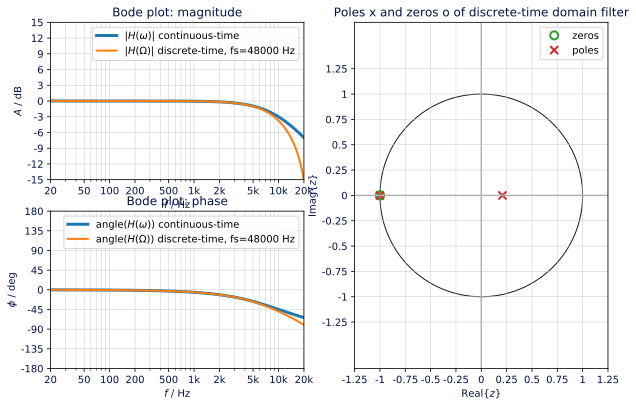

In [12]:
bode_plot(B, A, b, a)

#### With Frequency Prewarping

In the above example you see that the digital filter (z-domain, red) deviates from its analog (s-domain, blue) counterpart for frequencies near half of the sampling frequency. This deviation can be precisely resolved for one frequency. Performing such a matching is known as frequency prewarping. Typically, the -3.01 dB / -45 deg cut frequency is chosen for such frequency prewarping, but we are free to choose any other frequency if it fits our application.

Now then, we do the same procedure **with frequency prewarping**, in order that the intended analog $f_c$ matches the 'digital' $f_c$ in discrete-time domain.

$B$, $A$, $f_c$ and $\omega_c$ (`B`, `A`, `fc`, `wc`) remain unchanged. We use the `prewarping_f()` function on the cut frequency `fc` as

In [13]:
wcpre = audiofilter.f_prewarping(fc, fs)
print("wc=",wc/2/np.pi)
print("wcpre=",wcpre/2/np.pi)

wc= 10000.0
wcpre= 11723.89277804802


In the calulation of `A` and `B` every dependence of `wc` is to be exchanged with `wcpre`, leading to

In [14]:
Bpre = B
Apre = np.array([0, 1 / wcpre, 1])

The bilinear transform of these coefficients yields

In [15]:
b, a = audiofilter.bilinear_biquad(Bpre, Apre, fs) 

We plot our results, which indicate that analog and digital transfer function matches exactly in the low frequency region and precisely the -3.01 dB point at $f_c$.

B = [0. 0. 1.]
A = [0.0000000000000000e+00 1.5915494309189534e-05 1.0000000000000000e+00]
b = [0.4341737512063021 0.8683475024126042 0.4341737512063021]
a = [ 1.                   0.8683475024126042  -0.13165249758739586]


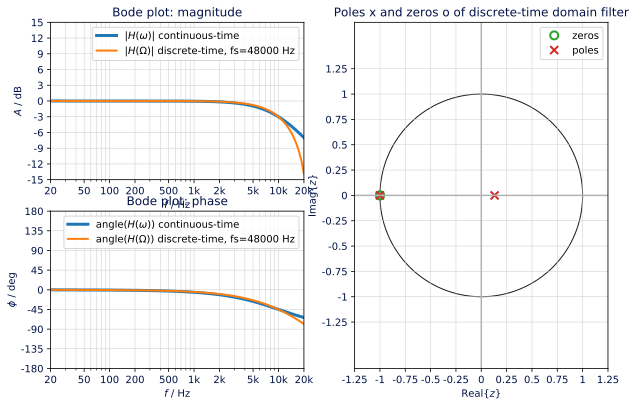

In [16]:
bode_plot(B, A, b, a)

Take a moment to check the differences in filter coefficients $a$ and $b$ of the filter versions **with frequency prewarping** vs. **without frequency prewarping**. These differences become more subtle for $f_c\ll f_s/2$.

### Definition of 1st / 2nd Order Filter Transfer Functions

In [audiofilter.py](audiofilter.py) we implemented functions to calculate filter coefficients of lowpass, highpass, allpass, bandpass, bandstop, shelving and parametric filters. These characteristics are very often used in audio applications, cf. e.g. [\cite{TietzeSchenk2002}](http://www.tietze-schenk.de/), \cite{Moschytz1981}, \cite{Christensen2003}, \cite{Zoelzer2008}, \cite{Zoelzer2011}, \cite{Bristow-Johnson1994}, \cite{Redmon2013}, \cite{ValimakiReiss2016}.

<a id="lowpass1st"></a>
### 1st Order Lowpass `lp1st`

\cite{Tietze1978}, \cite{Moschytz1981}


| $B_0$ | $B_1$ | $B_2$ | $A_0$ | $A_1$ | $A_2$ |
| :---: | :---: | :---: | :---: | :---: | :---: |
| 0 | 0 | 1 | 0 | $\frac{1}{\omega_\text{c}}$ | 1 |

with cut frequency $\omega_c=2\pi f_c$ in rad/s

B = [0. 0. 1.]
A = [0.0000000000000000e+00 1.5915494309189535e-04 1.0000000000000000e+00]
b = [0.061511768503621556 0.12302353700724311  0.061511768503621556]
a = [ 1.                   0.12302353700724311 -0.8769764629927569 ]


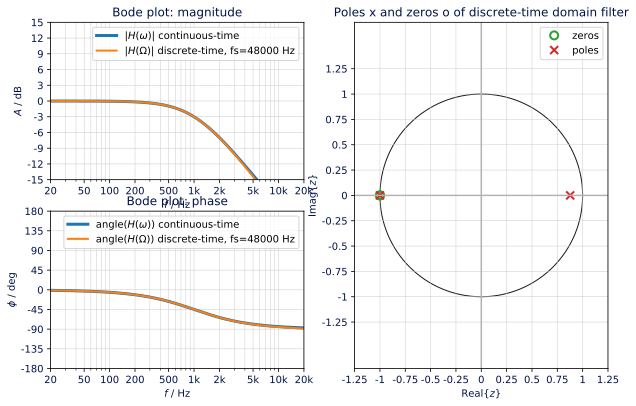

In [17]:
fc = 1000  # Hz
B, A, b, a = audiofilter.biquad_lp1st(fc, fs)
bode_plot(B, A, b, a)

<a id="lowpass2nd"></a>
### 2nd Order Lowpass `lp2nd`

\cite{Tietze1978}, \cite{Moschytz1981}

| $B_0$ | $B_1$ | $B_2$ | $A_0$ | $A_1$ | $A_2$ |
| :---: | :---: | :---: | :---: | :---: | :---: |
| 0 | 0 | 1 | $\frac{\text{b}_\text{i}}{\omega_\text{c}^2}$ | $\frac{\text{a}_\text{i}}{\omega_\text{c}}$ | 1 |

with cut frequency $\omega_c=2 \pi f_c$ in rad/s and filter characteristic coefficients $\text{b}_\text{i}$ and $\text{a}_\text{i}$ (see Appendix)

B = [0. 0. 1.]
A = [2.5330295910584447e-08 2.2507907903927655e-04 1.0000000000000000e+00]
b = [0.0039161266605473675 0.007832253321094735  0.0039161266605473675]
a = [ 1.                 -1.815341082704568   0.8310055893467575]


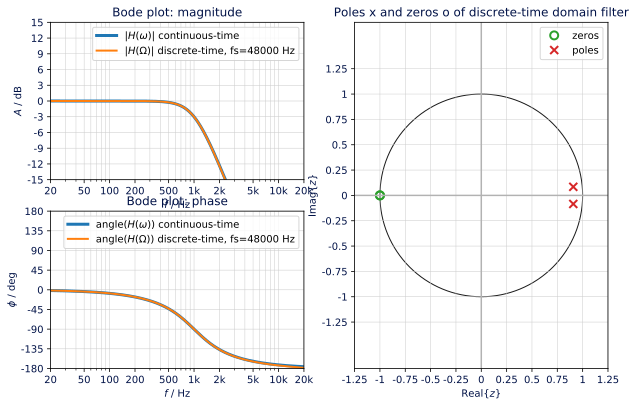

In [18]:
fc = 1000  # Hz
B, A, b, a = audiofilter.biquad_lp2nd(fc, fs)
bode_plot(B, A, b, a)

<a id="highpass1st"></a>
### 1st Order Highpass `hp1st`

\cite{Tietze1978}, \cite{Moschytz1981}

| $B_0$ | $B_1$ | $B_2$ | $A_0$ | $A_1$ | $A_2$ |
| :---: | :---: | :---: | :---: | :---: | :---: |
| 0  | $\frac{1}{\omega_\text{c}}$ | 0 | 0 | $\frac{1}{\omega_\text{c}}$ | 1 |

with cut frequency $\omega_c=2 \pi f_c$ in rad/s

B = [0.                     0.00015915494309189535 0.                    ]
A = [0.0000000000000000e+00 1.5915494309189535e-04 1.0000000000000000e+00]
b = [ 0.9384882314963784  0.                 -0.9384882314963784]
a = [ 1.                   0.12302353700724311 -0.8769764629927569 ]


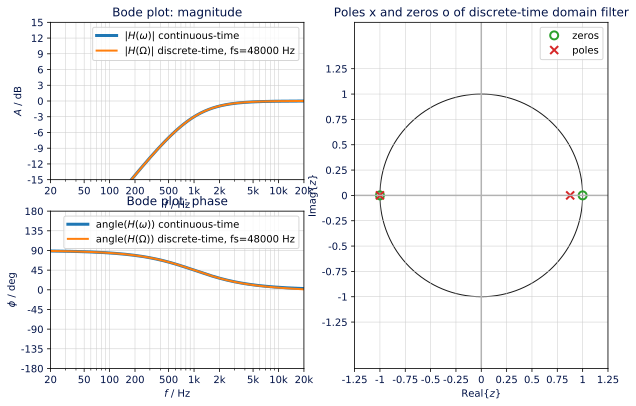

In [19]:
fc = 1000  # Hz
B, A, b, a = audiofilter.biquad_hp1st(fc, fs)
bode_plot(B, A, b, a)

<a id="highpass2nd"></a>
### 2nd Order Highpass `hp2nd`

\cite{Tietze1978}, \cite{Moschytz1981}

| $B_0$ | $B_1$ | $B_2$ | $A_0$ | $A_1$ | $A_2$ |
| :---: | :---: | :---: | :---: | :---: | :---: |
| $\frac{1}{\omega_\text{c}^2}$ | 0 | 0 | $\frac{1}{\omega_\text{c}^2}$ | $\frac{\text{a}_\text{i}}{\omega_\text{c}}$ | $\text{b}_\text{i}$ |

with cut frequency $\omega_c$ in rad/s and filter characteristic coefficients $\text{b}_\text{i}$ and $\text{a}_\text{i}$ (see Appendix)

B = [2.5330295910584447e-08 0.0000000000000000e+00 0.0000000000000000e+00]
A = [2.5330295910584447e-08 2.2507907903927655e-04 1.0000000000000000e+00]
b = [ 0.9115866680128314 -1.8231733360256628  0.9115866680128314]
a = [ 1.                 -1.815341082704568   0.8310055893467575]


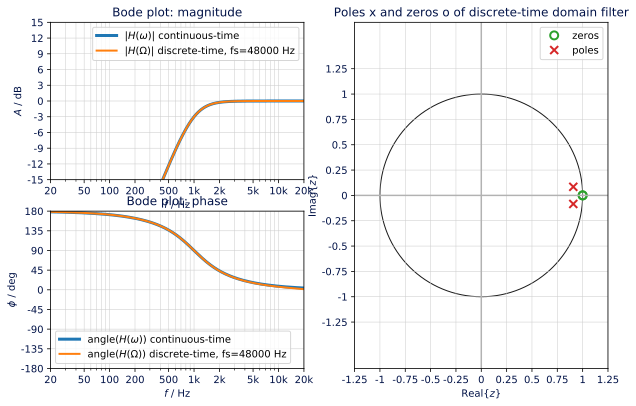

In [20]:
fc = 1000  # Hz
B, A, b, a = audiofilter.biquad_hp2nd(fc, fs)
bode_plot(B, A, b, a)

<a id="bandpass2nd"></a>
### 2nd Order Bandpass `bp2nd`

\cite{Tietze1978}, \cite{Moschytz1981}

| $B_0$ | $B_1$ | $B_2$ | $A_0$ | $A_1$ | $A_2$ |
| :---: | :---: | :---: | :---: | :---: | :---: |
| 0 | $\frac{1}{Q_\text{BP}\,\omega_\text{m}}$ | 0 | $\frac{1}{\omega_\text{m}^2}$ | $\frac{1}{Q_\text{BP}\,\omega_\text{m}}$ | 1 |

with mid frequency $\omega_m=2 \pi f_m$ in rad/s and bandpass quality $Q_\text{BP}$

B = [0.                     0.00023873241463784307 0.                    ]
A = [2.5330295910584447e-08 2.3873241463784307e-04 1.0000000000000000e+00]
b = [ 0.08934001866587332  0.                  -0.08934001866587332]
a = [ 1.                 -1.8057383179049802  0.8213199626682534]
fcut_low = 500.0 Hz
fmid = 1000 Hz
fcut_high = 2000.0 Hz
QBP = 0.6666666666666666


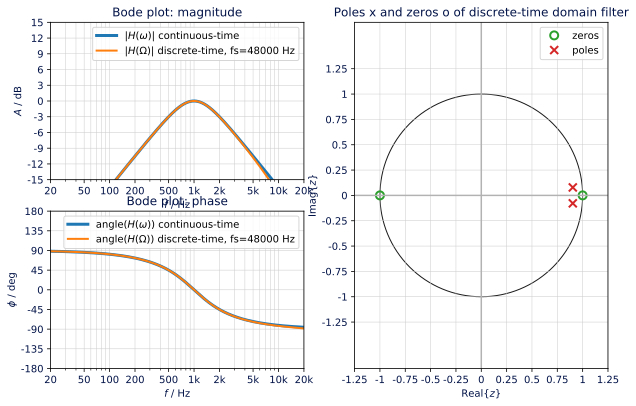

In [21]:
BW = 2  # bandwidth in octaves
fm = 1000  # Hz

fcl =  2**(-BW/2) * fm  # lower cut (-3 dB) frequency in Hz 
fch = 2**(+BW/2) * fm  # higher cut (-3 dB) frequency in Hz 
QBP = audiofilter.q_from_bw(BW)
np.testing.assert_allclose(QBP, fm / (fch-fcl))
B, A, b, a = audiofilter.biquad_bp2nd(fm, QBP, fs)

bode_plot(B, A, b, a)
print("fcut_low =", fcl, "Hz")
print("fmid =", fm, "Hz")
print("fcut_high =", fch, "Hz")
print("QBP =", QBP)

<a id="bandstop2nd"></a>
### 2nd Order Bandstop `bs2nd`

\cite{Tietze1978}, \cite{Moschytz1981}

| $B_0$ | $B_1$ | $B_2$ | $A_0$ | $A_1$ | $A_2$ |
| :---: | :---: | :---: | :---: | :---: | :---: |
$\frac{1}{\omega_\text{m}^2}$ | 0 | 1 | $\frac{1}{\omega_\text{m}^2}$ | $\frac{1}{Q_\text{BS}\,\omega_\text{m}}$ | 1 | 

with mid frequency $\omega_m=2 \pi f_m$ in rad/s and bandstop quality $Q_\text{BS}$

B = [2.5330295910584447e-08 0.0000000000000000e+00 1.0000000000000000e+00]
A = [2.5330295910584447e-08 2.3873241463784307e-04 1.0000000000000000e+00]
b = [ 0.9106599813341267 -1.8057383179049802  0.9106599813341267]
a = [ 1.                 -1.8057383179049802  0.8213199626682534]
fcut_low = 500.0 Hz
fmid = 1000 Hz
fcut_high = 2000.0 Hz
QBS = 0.6666666666666666


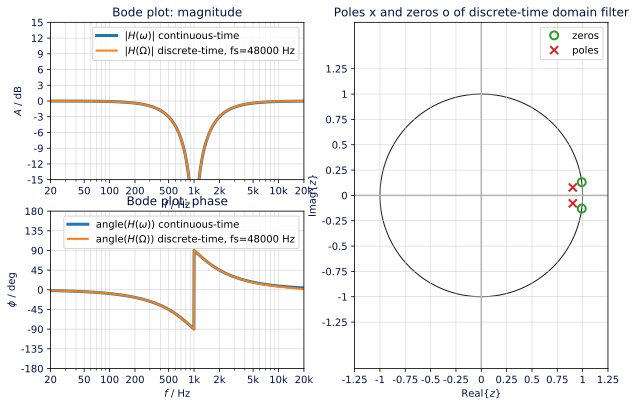

In [22]:
fm = 1000  # Hz
QBS = 2/3
B, A, b, a = audiofilter.biquad_bs2nd(fm, QBS, fs)
bode_plot(B, A, b, a)
print("fcut_low =", fcl, "Hz")
print("fmid =", fm, "Hz")
print("fcut_high =", fch, "Hz")
print("QBS =", QBS)

<a id="allpass1st"></a>
### 1st Order Allpass `ap1st`

\cite{Tietze1978}

| $B_0$ | $B_1$ | $B_2$ | $A_0$ | $A_1$ | $A_2$ |
| :---: | :---: | :---: | :---: | :---: | :---: |
| 0 | $\frac{-\text{a}_\text{i}}{\omega_c}$ | 1 | 0 | $\frac{+\text{a}_\text{i}}{\omega_c}$ | 1 | 

with cut frequency $\omega_c=2 \pi f_c$ in rad/s and filter characteristic coefficient $\text{a}_\text{i}$

B = [ 0.0000000000000000e+00 -1.5915494309189535e-04  1.0000000000000000e+00]
A = [0.0000000000000000e+00 1.5915494309189535e-04 1.0000000000000000e+00]
b = [-0.8769764629927569   0.12302353700724311  1.                 ]
a = [ 1.                   0.12302353700724311 -0.8769764629927569 ]


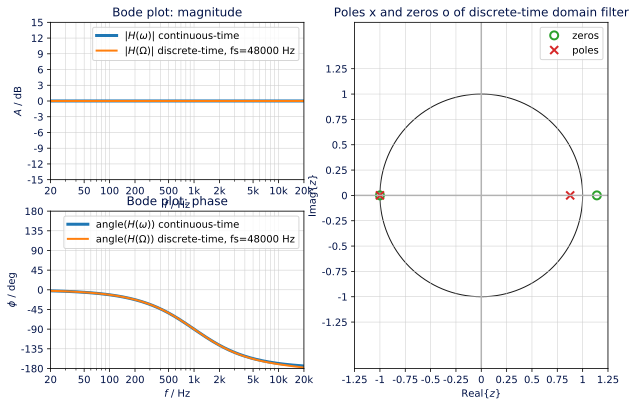

In [23]:
fc = 1000  # Hz
B, A, b, a = audiofilter.biquad_ap1st(fc, fs)
bode_plot(B, A, b, a)

<a id="allpass2nd"></a>
### 2nd Order Allpass `ap2nd`

\cite{Tietze1978}

| $B_0$ | $B_1$ | $B_2$ | $A_0$ | $A_1$ | $A_2$ |
| :---: | :---: | :---: | :---: | :---: | :---: |
| $\frac{\text{b}_\text{i}}{\omega_c^2}$ | $\frac{-\text{a}_\text{i}}{\omega_c}$ | 1 | $\frac{\text{b}_\text{i}}{\omega_c^2}$ | $\frac{+\text{a}_\text{i}}{\omega_c}$ | 1 |

with cut frequency $\omega_c=2 \pi f_c$ in rad/s and filter characteristic coefficients $\text{b}_\text{i}$ and $\text{a}_\text{i}$

B = [ 2.5330295910584447e-08 -2.2507907903927655e-04  1.0000000000000000e+00]
A = [2.5330295910584447e-08 2.2507907903927655e-04 1.0000000000000000e+00]
b = [ 0.8310055893467575 -1.815341082704568   1.                ]
a = [ 1.                 -1.815341082704568   0.8310055893467575]


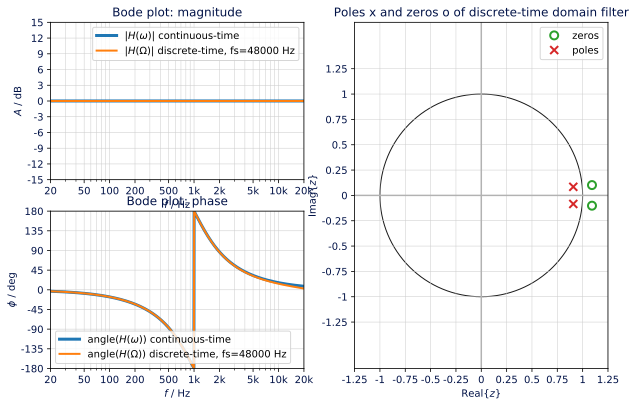

In [24]:
fc = 1000  #  Hz
B, A, b, a = audiofilter.biquad_ap2nd(fc, fs)
bode_plot(B, A, b, a)

<a id="peq2nd"></a>
### 2nd Order PEQ `peq2nd`

cf. \cite{Bristow-Johnson1994}, \cite{Christensen2003}, \cite{Zoelzer2008}, \cite{Zoelzer2011}

| | $B_0$ | $B_1$ | $B_2$ | $A_0$ | $A_1$ | $A_2$ |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| $G\leq0$ | $\frac{1}{\omega_\text{m}^2}$ | $\frac{\gamma}{Q_\text{BP}\,\omega_\text{m}}$ | 1 | $\frac{1}{\omega_\text{m}^2}$ | $\frac{\gamma/g}{Q_\text{BP}\,\omega_\text{m}}$ | 1 |
$G>0$ | $\frac{1}{\omega_\text{m}^2}$ | $\frac{\delta}{Q_\text{BP}\,\omega_\text{m}}$ | 1 | $\frac{1}{\omega_\text{m}^2}$ | $\frac{\delta/g}{Q_\text{BP}\,\omega_\text{m}}$ | 1 |       

with  $g=10^{\frac{G}{20}}$, mid frequency $\omega_m=2 \pi f_m$ in rad/s, quality $Q_\text{BP}$ and gain $G$ in dB
        
* **type I:** 
$\gamma=g\,,\delta=g$ 

for $G\gg 0$ bandwidth is similar to that of the 2nd order bandpass

for $G\ll 0$ bandwidth is similar to that of the 2nd order bandstop

* **type II:**
$\gamma=1\,,\delta=g$

for $G\gg 0$ bandwidth is similar to that of the 2nd order bandpass

for $G<0$ the transfer function is inverted from $G>0$

* **default: type III (one-half pad loss):**
$\gamma=g^{1/2}\,,\delta=g^{1/2}$

cut frequencies are located at $G/2$



B = [2.5330295910584447e-08 4.7633379028841317e-04 1.0000000000000000e+00]
A = [2.5330295910584447e-08 1.1964963846949948e-04 1.0000000000000000e+00]
b = [ 1.1397065711701546 -1.889962496723752   0.7665643374357936]
a = [ 1.                 -1.889962496723752   0.9062709086059483]


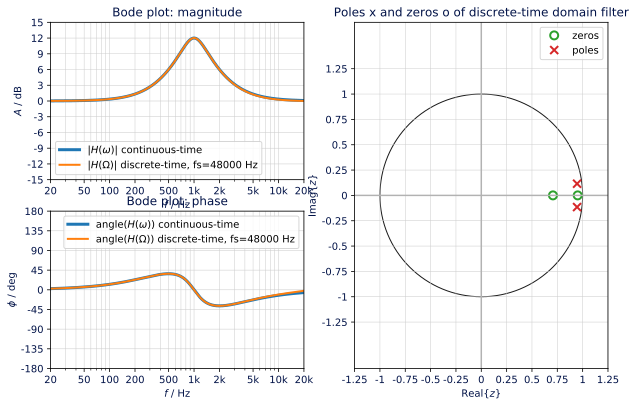

In [25]:
BW = 2  # bandwidth in octaves
fm = 1000  # Hz
G = 12  # dB
Q = audiofilter.q_from_bw(BW)
B, A, b, a = audiofilter.biquad_peq2nd(fm, G, Q, fs)
bode_plot(B, A, b, a)

<a id="lowshv1st"></a>
### 1st Order Low-Shelving `lshv1st`

cf. \cite{Christensen2003}, \cite{Zoelzer2008}, \cite{Zoelzer2011}

| | $B_0$ | $B_1$ | $B_2$ | $A_0$ | $A_1$ | $A_2$ |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| $G\leq0$ | 0 | $\frac{1}{\omega_\text{c}}$ | $\alpha^{+2}$ | 0 | $\frac{1}{\omega_\text{c}}$ | $g^{-1}\, \alpha^{+2}$ | 
| $G>0$ | 0 | $\frac{1}{\omega_\text{c}}$ | $g^{+1}\, \alpha^{-2}$ | 0 | $\frac{1}{\omega_\text{c}}$ | $\alpha^{-2}$ |

with $g=10^{\frac{G}{20}}$, cut frequency $\omega_c=2 \pi f_c$ in rad/s and gain $G$ in dB

* **type I:**
$\alpha=1$ 

for $G\gg 0$ cut frequency is at $G$-3 dB

for $G\ll 0$ cut frequency is at $G$+3 dB

* **type II:**
$\alpha=g^{+1/2}$

for $G\gg 0$ cut frequency is at +3 dB

for $G\ll 0$ cut frequency is at -3 dB
		
* **default: type III (one-half pad loss):**
$\alpha=g^{+1/4}$

cut frequency is located at $G/2$

B = [0.0000000000000000e+00 1.5915494309189535e-04 1.9952623149688793e+00]
A = [0.0000000000000000e+00 1.5915494309189535e-04 5.0118723362727224e-01]
b = [ 1.0948123130222311  0.2532341748159276 -0.8415781382063036]
a = [ 1.                   0.06360954877146535 -0.9363904512285347 ]


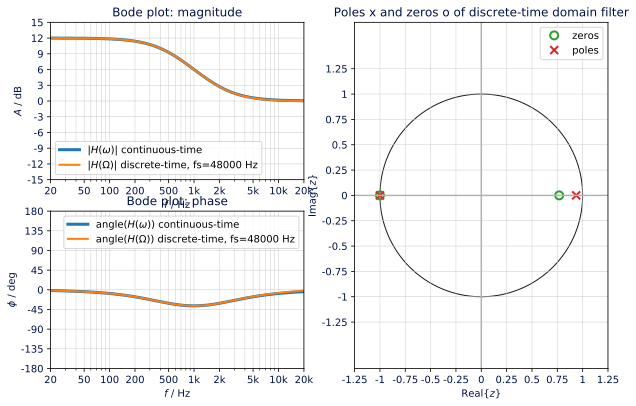

In [26]:
fc = 1000  # Hz
G = 12  # dB
B, A, b, a = audiofilter.biquad_lshv1st(fc, G, fs)
bode_plot(B, A, b, a)

<a id="lowshv2nd"></a>
### 2nd Order Low-Shelving `lshv2nd`

cf. \cite{Bristow-Johnson1994}, \cite{Christensen2003}, \cite{Zoelzer2008}, \cite{Zoelzer2011}

| | $B_0$ | $B_1$ | $B_2$ | $A_0$ | $A_1$ | $A_2$ |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| $G\leq0$ | $\frac{1}{\omega_\text{c}^2}$ | $\frac{\alpha^{+1}}{Q_\text{z}\,\omega_\text{c}}$ | $\alpha^{+2}$ | $\frac{1}{\omega_\text{c}^2}$ |  $\frac{g^{-1/2}\,\alpha^{+1}}{Q_\text{p}\,\omega_\text{c}}$ |  $g^{-1}\,\alpha^{+2}$ | 
|$G>0$ | $\frac{1}{\omega_\text{c}^2}$ | $\frac{g^{+1/2}\,\alpha^{-1}}{Q_\text{z}\,\omega_\text{c}}$ | $g^{+1}\,\alpha^{-2}$ | $\frac{1}{\omega_\text{c}^2}$ | $\frac{\alpha^{-1}}{Q_\text{p}\,\omega_\text{c}}$ | $\alpha^{-2}$ |

with $g=10^{\frac{G}{20}}$, cut frequency $\omega_c=2 \pi f_c$ in rad/s, gain $G$ in dB, zero's quality $Q_z$ and pole's quality $Q_p$

* **type I:**
$\alpha=1$ 

for $G\gg 0$ cut frequency is at $G$-3 dB if $Q_p=Q_z=1/\sqrt{2}$

for $G\ll 0$ cut frequency is at $G$+3 dB if $Q_p=Q_z=1/\sqrt{2}$

* **type II:**
$\alpha=g^{+1/2}$

for $G\gg 0$ cut frequency is at +3 dB if $Q_p=Q_z=1/\sqrt{2}$

for $G\ll 0$ cut frequency is at -3 dB if $Q_p=Q_z=1/\sqrt{2}$
		
* **default: type III (one-half pad loss):**
$\alpha=g^{+1/4}$

cut frequency is located at $G/2$

B = [2.5330295910584447e-08 3.1793264965209052e-04 1.9952623149688793e+00]
A = [2.5330295910584447e-08 1.5934378515892003e-04 5.0118723362727224e-01]
b = [ 1.0671759979201019 -1.8570000365012005  0.8219339635255971]
a = [ 1.                 -1.869022174734206   0.8770878232126937]


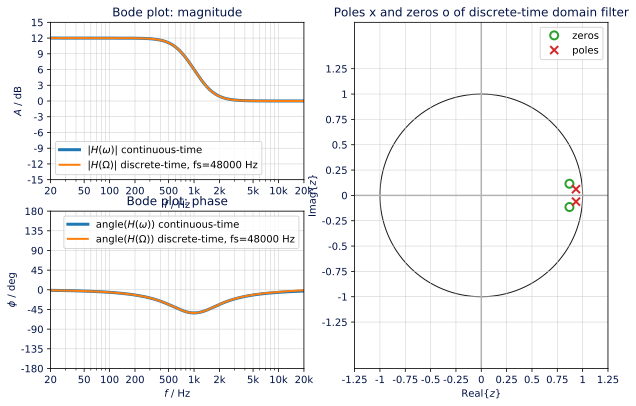

In [27]:
fc = 1000  # Hz
G = 12  # dB
B, A, b, a = audiofilter.biquad_lshv2nd(fc, G, fs)
bode_plot(B, A, b, a)

<a id="highshv1st"></a>
### 1st Order High-Shelving `hshv1st`

cf. \cite{Christensen2003}, \cite{Zoelzer2008}, \cite{Zoelzer2011}

| | $B_0$ | $B_1$ | $B_2$ | $A_0$ | $A_1$ | $A_2$ |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| $G\leq0$ | 0 | $\frac{\alpha^{+2}}{\omega_\text{c}}$ | 1 | 0 | $\frac{g^{-1}\,\alpha^{+2}}{\omega_\text{c}}$ | 1 | 
| $G>0$ | 0 | $\frac{g^{+1} \,\alpha^{-2}}{\omega_\text{c}}$ | 1 | 0  | $\frac{\alpha^{-2}}{\omega_\text{c}}$ | 1 |     

with $g=10^{\frac{G}{20}}$, cut frequency $\omega_c=2 \pi f_c$ in rad/s and gain $G$ in dB

* **type I:**
$\alpha=1$ 

for $G\gg 0$ cut frequency is at $G$-3 dB

for $G\ll 0$ cut frequency is at $G$+3 dB

* **type II:**
$\alpha=g^{+1/2}$

for $G\gg 0$ cut frequency is at +3 dB

for $G\ll 0$ cut frequency is at -3 dB
		
* **default: type III (one-half pad loss):**
$\alpha=g^{+1/4}$

cut frequency is located at $G/2$



B = [0.0000000000000000e+00 3.1755586019227534e-04 1.0000000000000000e+00]
A = [0.000000000000000e+00 7.976642564633298e-05 1.000000000000000e+00]
b = [ 3.6363051987835404   0.23130373288995468 -3.405001465893586  ]
a = [ 1.                   0.23130373288995468 -0.7686962671100454 ]


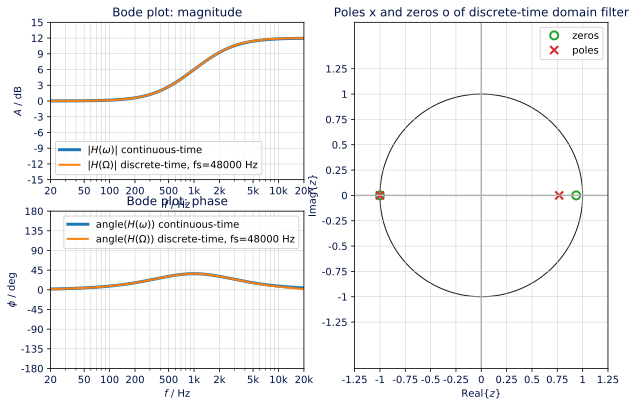

In [28]:
fc = 1000  # Hz
G = 12  # dB
B, A, b, a = audiofilter.biquad_hshv1st(fc, G, fs)
bode_plot(B, A, b, a)

<a id="highshv2nd"></a>
### 2nd Order High-Shelving `hshv2nd`

cf. \cite{Bristow-Johnson1994}, \cite{Christensen2003}, \cite{Zoelzer2008}, \cite{Zoelzer2011}

| | $B_0$ | $B_1$ | $B_2$ | $A_0$ | $A_1$ | $A_2$ |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| $G\leq0$ | $\frac{\alpha^{+2}}{\omega_\text{c}^2}$ | $\frac{\alpha^{+1}}{Q_\text{z}\,\omega_\text{c}}$ | 1 | $\frac{g^{-1}\,\alpha^{+2}}{\omega_\text{c}^2}$ | $\frac{g^{-1/2}\,\alpha^{+1}}{Q_\text{p}\,\omega_\text{c}}$| 1 |
| $G>0$ | $\frac{g^{+1}\,\alpha^{-2}}{\omega_\text{c}^2}$ | $\frac{g^{+1/2}\,\alpha^{-1}}{Q_\text{z}\,\omega_\text{c}}$ | 1 | $\frac{\alpha^{-2}}{\omega_\text{c}^2}$ | $\frac{\alpha^{-1}}{Q_\text{p}\,\omega_\text{c}}$ | 1 |

with $g=10^{\frac{G}{20}}$, cut frequency $\omega_c=2 \pi f_c$ in rad/s, gain $G$ in dB, zero's quality $Q_z$ and 
pole's quality $Q_p$

* **type I:**
$\alpha=1$ 

for $G\gg 0$ cut frequency is at $G$-3 dB if $Q_p=Q_z=1/\sqrt{2}$

for $G\ll 0$ cut frequency is at $G$+3 dB if $Q_p=Q_z=1/\sqrt{2}$

* **type II:**
$\alpha=g^{+1/2}$

for $G\gg 0$ cut frequency is at +3 dB if $Q_p=Q_z=1/\sqrt{2}$

for $G\ll 0$ cut frequency is at -3 dB if $Q_p=Q_z=1/\sqrt{2}$
		
* **default: type III (one-half pad loss):**
$\alpha=g^{+1/4}$

cut frequency is located at $G/2$

B = [5.054058485739946e-08 3.179326496520905e-04 1.000000000000000e+00]
A = [1.2695220934386025e-08 1.5934378515892003e-04 1.0000000000000000e+00]
b = [ 3.7304734301502065 -6.972337563207512   3.2719528204032353]
a = [ 1.                 -1.7401066366938958  0.7701953240398256]


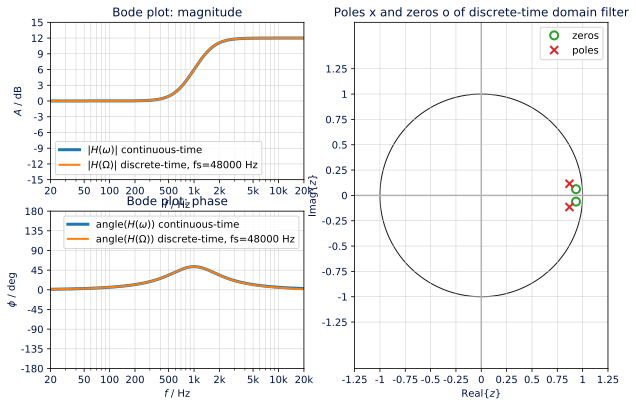

In [29]:
fc = 1000  # Hz
G = 12  # dB
B, A, b, a = audiofilter.biquad_hshv2nd(fc, G, fs)
bode_plot(B, A, b, a)

### Exercise

1.) Check the differences of the types I,II vs. III for the PEQ and shelving filters with regard to their cut frequencies.

Hints: 

* The **type III** filters as for PEQs and shelving filters consistently define the cut frequency as the point of half gain in dB.

* Can you define the half gain $G/2$ cut frequencies of type III for small gain/attenuation $|G| <3$ dB?

* Can you define the '3 dB cut frequencies' for small gain/attenuation $|G| <3$ dB for type I and II?

* Where are the '3dB cut frequencies' located for type I,II for large gain or large attenuation? 

* Check how the filters of your favorite audio software are implemented.

2.) Discuss the differences of the **sin**, **cos**, **tan**-style quality prewarping. For very high frequencies and rather small bandwidths the differences become obvious. 

#### Example: Different Types of High Shelve 2nd Order 

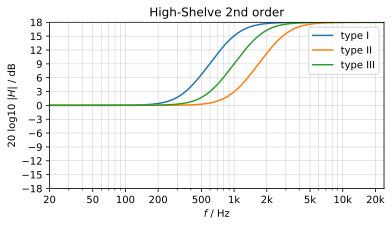

In [30]:
fc = 1000  # Hz
G = 18  # dB
B1, A1, b, a = audiofilter.biquad_hshv2nd(fc, G, fs, "I")  # fc at 15 dB
B2, A2, b, a = audiofilter.biquad_hshv2nd(fc, G, fs, "II")  # fc at 3 dB
B3, A3, b, a = audiofilter.biquad_hshv2nd(fc, G, fs, "III")  # fc at 9 dB
f = np.arange(1,fs/2,1)
s = 2*np.pi*f
s, H1 = signal.freqs(B1, A1, s)
s, H2 = signal.freqs(B2, A2, s)
s, H3 = signal.freqs(B3, A3, s)

x = np.column_stack((f, f, f))
y = np.column_stack((H1, H2, H3))
title = 'High-Shelve 2nd order'
legend = ["type I", "type II", "type III"]
magnitude_plot(x, y, title, legend)

#### Example: Different Types of PEQ 2nd Order for Boosting

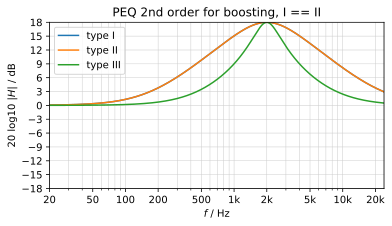

In [31]:
BW = 2  # bandwidth in octaves
fm = 2000  # mid frequency in Hz; using fm=1000 and BW=2, then fc is at 1 kHz
G = 18  # dB
QBP = audiofilter.q_from_bw(BW)
B1, A1, b, a = audiofilter.biquad_peq2nd(fm, G, QBP, fs, "I")  # fc at 15 dB
B2, A2, b, a = audiofilter.biquad_peq2nd(fm, G, QBP, fs, "II")  # fc at 15 dB
B3, A3, b, a = audiofilter.biquad_peq2nd(fm, G, QBP, fs, "III")  # fc at 9 dB
f = np.arange(1,fs/2,1)
s = 2*np.pi*f
s, H1 = signal.freqs(B1, A1, s)
s, H2 = signal.freqs(B2, A2, s)
s, H3 = signal.freqs(B3, A3, s)
np.testing.assert_allclose(H1, H2)  # type I and II are equal for boosting

x = np.column_stack((f, f, f))
y = np.column_stack((H1, H2, H3))
title = 'PEQ 2nd order for boosting, I == II'
legend = ["type I", "type II", "type III"]
magnitude_plot(x, y, title, legend)

#### Example: Different Types of PEQ 2nd Order for Cutting

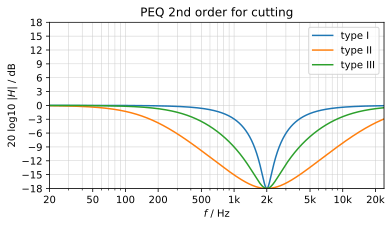

In [32]:
BW = 2  # bandwidth in octaves
fm = 2000  # mid frequency in Hz; using fm=1000 and BW=2, then fc is at 1 kHz
G = -18  # dB
QBP = audiofilter.q_from_bw(BW)
B1, A1, b, a = audiofilter.biquad_peq2nd(fm, G, QBP, fs, "I")  # fc at -3dB
B2, A2, b, a = audiofilter.biquad_peq2nd(fm, G, QBP, fs, "II")  # fc at -15dB
B3, A3, b, a = audiofilter.biquad_peq2nd(fm, G, QBP, fs, "III")  # fc at -9dB
f = np.arange(1,fs/2,1)
s = 2*np.pi*f
s, H1 = signal.freqs(B1, A1, s)
s, H2 = signal.freqs(B2, A2, s)
s, H3 = signal.freqs(B3, A3, s)

x = np.column_stack((f, f, f))
y = np.column_stack((H1, H2, H3))
title = 'PEQ 2nd order for cutting'
legend = ["type I", "type II", "type III"]
magnitude_plot(x, y, title, legend)

#### Example: Different Types for Quality Prewarping for PEQ 2nd Order 

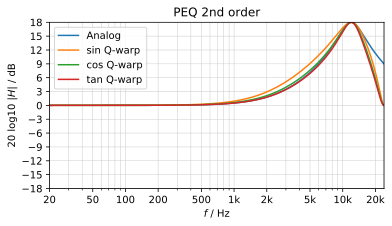

In [33]:
BW = 2  # bandwidth in octaves
fm = 12000  # Hz
G = 18  # dB
QBP = audiofilter.q_from_bw(BW)
B, A, bsin, asin = audiofilter.biquad_peq2nd(fm, G, QBP, fs, "III", "sin")
B, A, bcos, acos = audiofilter.biquad_peq2nd(fm, G, QBP, fs, "III", "cos")
B, A, btan, atan = audiofilter.biquad_peq2nd(fm, G, QBP, fs, "III", "tan")
f = np.arange(1,fs/2,1)
s = 2*np.pi*f
W = s/fs
s, H = signal.freqs(B, A, 2*np.pi*f)
W, Hsin = signal.freqz(bsin, asin, W)
W, Hcos = signal.freqz(bcos, acos, W)
W, Htan = signal.freqz(btan, atan, W)

x = np.column_stack((f, f, f, f))
y = np.column_stack((H, Hsin, Hcos, Htan))
title = 'PEQ 2nd order'
legend = ["Analog","sin Q-warp","cos Q-warp","tan Q-warp"]
magnitude_plot(x, y, title, legend)

### Excursus: Higher Order Filters

In audio signal processing also IIR filters of higher order are applied. However, they will be usually split into second order sections for series or parallel connection. Note that the group delay of an IIR filter increases with higher filter order. 



A prominent example of using higher order IIR filters is found in loudspeaker engineering. For a multi-way loudspeaker each driver must only be driven within an appropriate intended frequency range. This is usually realized with a bandpass filter that is built from a series connection of a higher order lowpass and a higher order highpass filter. Thus, each loudspeaker exhibits its own bandpass filter. The acoustic summation of all the driver's generated sound pressures then yields the desired full audio bandwidth in the sonic domain.

#### Linkwitz-Riley Crossover

Consider the following two driver application, in which the same bandpass characteristic is used for the low (LF) and high (HF) frequency driver. A special and often used case is achieved, when **two equal** 2nd-order **Butterworth** high-/low-pass filters **in series** built a 4th-order so called **[Linkwitz-Riley](http://www.linkwitzlab.com/crossovers.htm)** high-/low-pass filter.

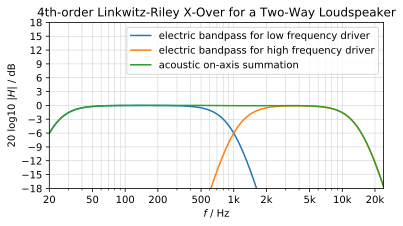

In [34]:
f = np.arange(1,fs/2,1)
s = 2*np.pi*f
bi = 1 
ai = np.sqrt(2)  # Butterworth

# low frequency driver range
fLow_HP = 20
fLow_LP = 1000
# high frequency driver range
fHigh_HP = fLow_LP
fHigh_LP = 15000

# LOW frequency driver -> highpass
B, A, b, a = audiofilter.biquad_hp2nd(fLow_HP, fs, bi, ai)
s, LF_HP = signal.freqs(B, A, s)
# LOW frequency driver -> lowpass
B, A, b, a = audiofilter.biquad_lp2nd(fLow_LP, fs, bi, ai)
s, LF_LP = signal.freqs(B, A, s)
# HIGH frequency driver -> highpass
B, A, b, a = audiofilter.biquad_hp2nd(fHigh_HP, fs, bi, ai)
s, HF_HP = signal.freqs(B, A, s)
# HIGH frequency driver -> lowpass
B, A, b, a = audiofilter.biquad_lp2nd(fHigh_LP, fs, bi, ai)
s, HF_LP = signal.freqs(B, A, s)

# Butterworth Lowpass^2 * Butterwoth Highpass^2
# results in a Linkwitz-Riley Bandpass: 
LF = (LF_HP*LF_HP) * (LF_LP*LF_LP)
HF = (HF_HP*HF_HP) * (HF_LP*HF_LP)
LF[0] = 1e-15  # avoid zero at DC
HF[0] = 1e-15  # avoid zero at DC
# simulation of the acoustic summation on both driver's middle axis:
AcousticSum = LF + HF  

x = np.column_stack((f, f, f))
y = np.column_stack((LF, HF, AcousticSum))
title = '4th-order Linkwitz-Riley X-Over for a Two-Way Loudspeaker'
legend = ["electric bandpass for low frequency driver","electric bandpass for high frequency driver","acoustic on-axis summation"]
magnitude_plot(x, y, title, legend)

#### Exercise

* What filter characteristic has the acoustic sum? To explore it in detail, plot and discuss the phase of the Linwitz-Riley filters as well as of the acoustic sum.

* Why sum the magnitudes of the low and the high frequency driver precisely to 0 dB at $f_c$ for the chosen example? Hints: Which phase shift exhibits the sum transfer function? What is the magnitude of the low and high frequency driver bandpass exactly at the crossover frequency?

* Is this handling also possible with normal Butterworth filters? Why?

* What happens for a 6th-order Linkwitz-Riley Crossver, i.e. built from 3rd-order Butterworth filters? See the coefficients of a 3rd-order BW filter below. Pay special attention to the phase and polarity of the LF and HF driver!

### Appendix

#### Butterworth Filter Characteristics

Higher order filter design can be realized with series connection of biquads. The coefficients for **Butterworth** type are e.g. given as, cf. \cite{Tietze1978} 

$\text{a}_\text{i}$ $\text{b}_\text{i}$     

**1st order**

1.0000 0.0000 

**2nd order**

1.4142 1.0000 (used in the example above)

**3rd order** (2 biquads in series connection with different bi, ai)

1.0000 0.0000

1.0000 1.0000

**4th order** (2 biquads in series connection with different bi, ai)

1.8478 1.0000 

0.7654 1.0000

Other common filter characteristics are Bessel, Elliptic, Chebychev.

#### Zoelzer PEQ (Type II, no Q prewarp)
We check type of \cite[Table 2.4]{Zoelzer2011} # U. Zoelzer (2011): "DAFX - Digital Audio Effects", 2nd, Wiley, Table 2.4:

In [35]:
fm = 1000
Q = 2/3
G = 12   
B, A, b, a = audiofilter.biquad_peq2nd(fm, G, Q, fs, filter_type="II", q_warp_method="NoQPreWarp")
bZ, aZ = audiofilter.biquad_peq2nd_zoelzer(fm, G, Q, fs)
np.testing.assert_allclose(bZ, b)
np.testing.assert_allclose(aZ, a)

#### RBJ PEQ (Type III, Q prewarp: sin)
We check type \cite(Bristow-Johnson1994), eq. (16)

Robert Bristow-Johnson (1994): "The equivalence of various methods of
computing biquad coefficients for audio parametric equalizers."
In: Proc. of 97th AES Convention, San Fransisco, eq. (16)

In [36]:
fm = 1000
Q = 2/3
G = 12  
B, A, b, a = audiofilter.biquad_peq2nd(fm, G, Q, fs, filter_type="III", q_warp_method="sin")
bR, aR = audiofilter.biquad_peq2nd_RBJ(fm, G, Q, fs)
np.testing.assert_allclose(bR, b)
np.testing.assert_allclose(aR, a)

#### Zoelzer 2nd Order Low-Shelving (Type I, Qz=Qp=1/sqrt(2))
We check type of \cite[Table 2.3]{Zoelzer2011} # U. Zoelzer (2011): "DAFX - Digital Audio Effects", 2nd, Wiley, Table 2.3:

In [37]:
fc = 1000
G = 12
B, A, b, a = audiofilter.biquad_lshv2nd(fc, G, fs, filter_type="I", qz=1/np.sqrt(2), qp=1/np.sqrt(2))    
bZ, aZ = audiofilter.biquad_lshv2nd_Zoelzer(fc, G, fs)   
np.testing.assert_allclose(bZ, b)
np.testing.assert_allclose(aZ, a)

#### RBJ 2nd Order Low-Shelving (Type III, Qz=Qp=1/sqrt(2) -> S = 1)
We check type of Robert Bristow-Johnson [Audio EQ Cookbook](http://www.musicdsp.org/files/Audio-EQ-Cookbook.txt)

In [38]:
fc = 1000
G = 1
S = 1
B, A, b, a = audiofilter.biquad_lshv2nd(fc, G, fs, filter_type="III", qz=1/np.sqrt(2), qp=1/np.sqrt(2))   
bR, aR = audiofilter.biquad_lshv2nd_RBJ(fc, G, S, fs) 
np.testing.assert_allclose(bR, b)
np.testing.assert_allclose(aR, a)

#### Zoelzer 2nd Order High-Shelving (Type I, Qz=Qp=1/sqrt(2))
We check type of \cite[Table 2.3]{Zoelzer2011} # U. Zoelzer (2011): "DAFX - Digital Audio Effects", 2nd, Wiley, Table 2.3:

In [39]:
fc = 1000
G = 12
B, A, b, a = audiofilter.biquad_hshv2nd(fc, G, fs, filter_type="I", qz=1/np.sqrt(2), qp=1/np.sqrt(2))    
bZ, aZ = audiofilter.biquad_hshv2nd_Zoelzer(fc, G, fs)   
np.testing.assert_allclose(bZ, b)
np.testing.assert_allclose(aZ, a)

#### RBJ 2nd Order High-Shelving (Type III, Qz=Qp=1/sqrt(2) -> S = 1)
We check type of Robert Bristow-Johnson [Audio EQ Cookbook](http://www.musicdsp.org/files/Audio-EQ-Cookbook.txt)

In [40]:
fc = 1000
G = 12
S = 1
B, A, b, a = audiofilter.biquad_hshv2nd(fc, G, fs, filter_type="III", qz=1/np.sqrt(2), qp=1/np.sqrt(2))   
bR, aR = audiofilter.biquad_hshv2nd_RBJ(fc, G, S, fs) 
np.testing.assert_allclose(bR, b)
np.testing.assert_allclose(aR, a)

### References

Please see the [biblio.bib](biblio.bib) for the cited references.

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Sascha Spors, Digital Signal Processing - Lecture notes featuring computational examples*.